In [ ]:
!pip install -U bitsandbytes transformers accelerate lime captum

In [1]:
from google.colab import drive, files
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import sys

path = os.getcwd()
while True:
    if 'utils.py' in os.listdir(path):
        if path not in sys.path:
            sys.path.append(path)
        break
    new_path = os.path.dirname(path)
    if new_path == path:
        print("utils.py not found in any parent folder. Please upload.")
        upload_utils = files.upload()
        break
    path = new_path

import utils
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch

c:\Users\User\anaconda3\envs\nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Global Parameters of Notebook
global_params = {'dataset_type': 'scitail',
                'quantization': '8bit',
                'training_mode': 'zero shot',
                'model_id': 'meta-llama/Llama-3.1-8B-Instruct'}

# Create checkpoint path
checkpoint_path = utils.create_checkpoint_path(params=global_params)

Saving to: c:\Users\User\iCloudDrive\Desktop\DAMA_EAP\NLI_Study\Notebooks\Scitail_Notebooks\Scitail_Llama_3.1_8B_Instruct\Zero-Shot\checkpoint_scitail_Llama_3.1_8B_Instruct_8bit_zero_shot.pt


In [4]:
utils.hf_login("HF_TOKEN")

In [5]:
# Quantization configuration
quantization_config = BitsAndBytesConfig(
    load_in_8bit=True
)

tokenizer = AutoTokenizer.from_pretrained(global_params['model_id'])
model = AutoModelForCausalLM.from_pretrained(
    global_params['model_id'],
    device_map="auto",
    quantization_config=quantization_config,
    attn_implementation="eager"
    )

# Add padding token to the tokenizer and change padding side
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

# Change the model to evaluation mode
model.eval()

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear8bitLt(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear8bitLt(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear8bitLt(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear8bitLt(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear8bitLt(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (

In [6]:
files.upload()
scitail_test = pd.read_csv('scitail_test.csv')

Saving scitail_test.csv to scitail_test.csv


In [ ]:
scitail_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   premise                     2126 non-null   object
 1   hypothesis                  2126 non-null   object
 2   label                       2126 non-null   object
 3   hypothesis_graph_structure  2126 non-null   object
dtypes: object(4)
memory usage: 66.6+ KB


In [ ]:
scitail_test.head(10)

,premise,hypothesis,label,hypothesis_graph_structure
0,Based on the list provided of the uses of subs...,"If a substance has a ph value greater than 7,t...",neutral,a substance<>has<>a ph value greater than 7
1,If one or two base pairs are change...,Invertebrates (and higher animals) can also be...,neutral,Invertebrates (and higher animals<>can be plac...
2,"At high temperatures, the solid dye converts i...",Gases and liquids become solids at low tempera...,neutral,Gases and liquids<>become<>solids
3,Chapter 11 Gas and Kinetic Theory .,The behavior of ideal gases is explained by ki...,neutral,The behavior of ideal gases<>is explained<>by ...
4,Both the continental crust and the oceanic cru...,Gabbro is a dark dense rock that can be found ...,neutral,Gabbro<>is<>a dark dense rock that can be foun...
5,The phylum for common marigolds is angiosperms.,Angiosperms are the most successful phylum of ...,neutral,Angiosperms<>are<>the most successful phylum o...
6,Lyme Disease is caused by a bacterium that's ...,Lyme disease is caused by bacteria.,entails,Lyme disease<>is caused<>by bacteria
7,Corolla Collective term for all the petals of ...,All of the petals together are called a corolla.,entails,All of the petals<>together are called<>a corolla
8,A polyploid is simply an organism that contain...,A(n) polyploid is an individual with more than...,entails,A(n) polyploid<>is<>an individual with more th...
9,Because type 1 diabetes is a relatively rare d...,Diabetes is unpreventable in the type one form...,neutral,Diabetes<>is<>unpreventable$$$it<>is<>of the s...


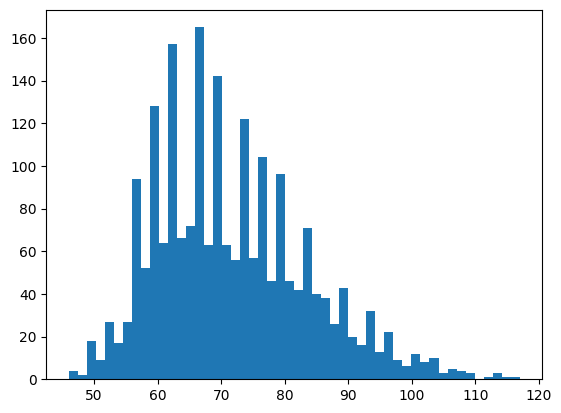

Max prompt length: 117
Max label length: 2


In [ ]:
# Find the max_length for tokenization to avoid wasting computing.
utils.find_max_length(scitail_test, tokenizer=tokenizer, dataset_type=global_params['dataset_type'])

In [ ]:
prompt_lengths, _ = utils.get_lengths(scitail_test, tokenizer, global_params['dataset_type'])
df = pd.DataFrame(prompt_lengths, columns=["length"])
n = (df["length"] > 117).sum()
percent = round(n/len(df)*100, 3)
print("Number of examples that have over 117 tokens and will be truncated:", n, "out of", len(df), "examples or", percent, "%")

Number of examples that have over 117 tokens and will be truncated: 0 out of 2126 examples or 0.0 %


In [22]:
# Define dataset and create a dataloader.
dataset_test = utils.MyDataset(dataframe=scitail_test,
                               tokenizer=tokenizer,
                               dataset_type=global_params['dataset_type'],
                               prompt_max_length=117,
                               label_max_length=3)

batch_size = 25 # Change batch size according to GPU
dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [21]:
# Test
predictions, gold_labels, batch_probs = utils.test_run(model=model,
                                          dataloader=dataloader,
                                          tokenizer=tokenizer,
                                          dataset_type=global_params['dataset_type'])

for i, pair in enumerate(zip(predictions, gold_labels)):
    print(pair, batch_probs[i])

('entails', 'neutral') tensor([0.6419, 0.3581], device='cuda:0')
('neutral', 'neutral') tensor([0.1518, 0.8482], device='cuda:0')
('neutral', 'neutral') tensor([0.1891, 0.8109], device='cuda:0')
('neutral', 'neutral') tensor([0.4900, 0.5100], device='cuda:0')
('neutral', 'neutral') tensor([0.3484, 0.6516], device='cuda:0')
('neutral', 'neutral') tensor([0.4318, 0.5682], device='cuda:0')
('entails', 'entails') tensor([0.5658, 0.4342], device='cuda:0')
('entails', 'entails') tensor([0.8103, 0.1897], device='cuda:0')
('neutral', 'entails') tensor([0.3467, 0.6533], device='cuda:0')
('neutral', 'neutral') tensor([0.2549, 0.7451], device='cuda:0')
('neutral', 'neutral') tensor([0.3361, 0.6639], device='cuda:0')
('entails', 'neutral') tensor([0.5716, 0.4284], device='cuda:0')
('entails', 'entails') tensor([0.5981, 0.4019], device='cuda:0')
('neutral', 'neutral') tensor([0.3156, 0.6844], device='cuda:0')
('entails', 'neutral') tensor([0.5311, 0.4689], device='cuda:0')
('neutral', 'neutral') te

In [ ]:
from tqdm import tqdm

# Load checkpoint if it exists
predicted_labels, gold_labels, start_batch = utils.load_checkpoint(checkpoint_path=checkpoint_path)
labels = utils.get_labels(global_params['dataset_type'])

# Loop over the batches
with torch.no_grad():
    for i, batch in enumerate(tqdm(dataloader, desc="Evaluating", unit="batch")):

        # Continue from last checkpoint
        if i < start_batch:
            continue

        input_ids_batch = batch["input_ids"].to(model.device) # Move to GPU
        attention_mask_batch = batch["attention_mask"].to(model.device) # Move to GPU
        gold_labels_batch = batch["labels"] # Keep to CPU

        batch_probs = utils.get_model_probs(batch_input_ids=input_ids_batch,
                                      batch_attention_mask=attention_mask_batch,
                                      dataset_type=global_params['dataset_type'],
                                      model=model,
                                      tokenizer=tokenizer)

        # Try to catch NaN values
        if torch.isnan(batch_probs).any():
            print("Warning: NaNs detected in batch_probs")

        batch_pred_indices = torch.argmax(batch_probs, dim=1)
        batch_pred_labels = [labels[i] for i in batch_pred_indices]

        predicted_labels.extend(batch_pred_labels)
        gold_labels.extend(gold_labels_batch)

        # Save checkpoint
        if i % 50 == 0 or i == len(dataloader) - 1:
            torch.save({"predicted_labels": predicted_labels,
                        "gold_labels": gold_labels,
                        "batch_no": i+1}, checkpoint_path)

            print(f"Checkpoint saved: {i+1}, {checkpoint_path}")

No checkpoint found.


Evaluating:   1%|          | 1/86 [00:05<08:17,  5.86s/batch]

Checkpoint saved: 1, /content/drive/MyDrive/eval_checkpoints/checkpoint_scitail_Llama_3.1_8B_Instruct_8bit_zero_shot.pt


Evaluating:  59%|█████▉    | 51/86 [04:53<03:20,  5.74s/batch]

Checkpoint saved: 51, /content/drive/MyDrive/eval_checkpoints/checkpoint_scitail_Llama_3.1_8B_Instruct_8bit_zero_shot.pt


Evaluating: 100%|██████████| 86/86 [08:09<00:00,  5.69s/batch]

Checkpoint saved: 86, /content/drive/MyDrive/eval_checkpoints/checkpoint_scitail_Llama_3.1_8B_Instruct_8bit_zero_shot.pt


Checkpoint found.
Accuracy: 0.7422.
 F1 Score: 0.7283.
 Matthew's Correlation Coefficient: 0.4571.
 Cohen's Kappa Score: 0.4567.


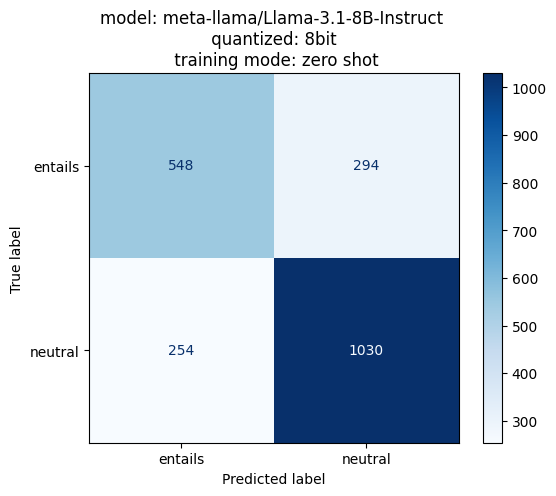

In [ ]:
# Calculate metrics for batch_size = 24 and after padding fix
predicted_labels, gold_labels, _ = utils.load_checkpoint(checkpoint_path)
utils.evaluate_metrics(predicted_labels=predicted_labels, gold_labels=gold_labels, params=global_params)